In [33]:
from pathlib import Path
import pandas as pd
import numpy as np
import yaml
from ms_pred.common.plot_utils import *
import pickle
import json
import copy 
set_style()

In [13]:
dataset_names = ["nist20", "canopus_train_public"]

In [27]:

names = [
    "CFM-ID",
    "3DMolMS",
    "FixedVocab",
    "FixedVocab (with zero)",
    "NEIMS (FFN)",
    "NEIMS (GNN)",
    "SCARF"
]


dataset_to_res = {}
for dataset_name in dataset_names:
    results_files = [
        f"../results/cfm_id_{dataset_name}/split_1/preds/pred_eval.yaml",
        f"../results/molnetms_baseline_{dataset_name}/split_1/preds/pred_eval.yaml",
        f"../results/graff_ms_baseline_{dataset_name}/split_1/preds/pred_eval.yaml",
        f"../results/graff_ms_baseline_{dataset_name}_with_zero/split_1/preds/pred_eval.yaml",
        f"../results/ffn_baseline_{dataset_name}/split_1/preds/pred_eval.yaml",
        f"../results/gnn_baseline_{dataset_name}/split_1/preds/pred_eval.yaml",
        f"../results/scarf_inten_{dataset_name}/split_1/preds/pred_eval.yaml",
    ]

    yaml_files = {i: yaml.safe_load(open(j, "r")) for i, j in zip(names, results_files)}
    dataset_to_res[dataset_name] = yaml_files

In [38]:

name_to_time = {
    "CFM-ID": "../results/cfm_id_nist20_timer/time_out.json", 
    "3DMolMS": "../results/molnetms_baseline_nist20/split_1/time_out.json",
    "FixedVocab": "../results/graff_ms_baseline_nist20/split_1/time_out.json",
    "FixedVocab (with zero)": "../results/graff_ms_baseline_nist20/split_1/time_out.json",
    "NEIMS (FFN)": "../results/ffn_baseline_nist20/split_1/time_out.json",
    "NEIMS (GNN)": "../results/gnn_baseline_nist20/split_1/time_out.json",
    "SCARF": "../results/scarf_inten_nist20/split_1/time_out.json"
}
name_to_seconds = {i: yaml.safe_load(open(j, "r"))["time (s)"] for i, j in name_to_time.items()}

In [39]:
dataset_to_res['nist20']['SCARF'].keys()

dict_keys(['avg_cos_sim', 'avg_cos_sim_zero_pep', 'avg_coverage', 'avg_frac_valid', 'avg_len_pred', 'avg_len_targ', 'avg_mse', 'avg_overlap_coeff', 'data_folder', 'dataset', 'individuals', 'sem_cos_sim', 'sem_cos_sim_zero_pep', 'sem_coverage', 'sem_frac_valid', 'sem_len_pred', 'sem_len_targ', 'sem_mse', 'sem_overlap_coeff', 'std_cos_sim', 'std_cos_sim_zero_pep', 'std_coverage', 'std_frac_valid', 'std_len_pred', 'std_len_targ', 'std_mse', 'std_overlap_coeff'])

In [40]:
out_df = []
for dataset_name, yaml_files in dataset_to_res.items():
    for k, v in yaml_files.items():
        new_entry = {
            "Method": k, 
            "Cosine sim.": v['avg_cos_sim'],
            "Cosine sim. sem": v['sem_cos_sim'],
            "Cosine sim. (no PEP)": v['avg_cos_sim_zero_pep'],
            "Cosine sim. sem (no PEP)": v['sem_cos_sim_zero_pep'],
            "Coverage": v["avg_coverage"],
            "Coverage sem": v["sem_coverage"],
            "Valid": v['avg_frac_valid'],
            "Valid sem": v['sem_frac_valid'],
            "Time (s)": name_to_seconds[k],
            "Dataset": dataset_name,

        }
        out_df.append(new_entry)
out_df = pd.DataFrame(out_df)
    

In [41]:
out_df_pivot = out_df.pivot_table(index="Method", columns="Dataset", values=["Cosine sim.", "Coverage",  "Valid", "Time (s)",])
out_df_pivot_sorted = out_df_pivot.loc[names]

out_df_pivot_sorted = out_df_pivot_sorted.swaplevel(0, 1, axis=1).round(3)

metric_order = {"Cosine sim.": 1, "Coverage": 2, "Valid": 3, "Time (s)": 4}
metric_order = ["Cosine sim.", "Coverage", "Valid", "Time (s)"]
dataset_order = {"nist20": 2, "canopus_train_public": 1,}
dataset_order = ["canopus_train_public", "nist20"]


# Create a new MultiIndex with the custom sort order
new_index = pd.MultiIndex.from_product([dataset_order, metric_order], names=['Dataset', 'Metric'])

out_df_pivot_sorted = out_df_pivot_sorted.loc[:, new_index]

# Drop time
out_df_pivot_sorted = out_df_pivot_sorted.drop(columns = [('canopus_train_public', "Time (s)")])

# Sort columns and make time last
out_df_pivot_sorted.index.name = None
display(out_df_pivot_sorted)
latex = out_df_pivot_sorted.to_latex(caption="Spectra prediction accuracy", label="tab:spec_acc")
print(latex)

Dataset                canopus_train_public                      nist20  \
                                Cosine sim. Coverage  Valid Cosine sim.   
CFM-ID                                0.368    0.232  1.000       0.371   
3DMolMS                               0.394    0.507  0.921       0.508   
FixedVocab                            0.479    0.548  0.997       0.587   
FixedVocab (with zero)                0.563    0.563  0.997       0.688   
NEIMS (FFN)                           0.494    0.528  0.948       0.614   
NEIMS (GNN)                           0.520    0.552  0.942       0.689   
SCARF                                 0.534    0.553  1.000       0.713   

Dataset                                           
                       Coverage  Valid  Time (s)  
CFM-ID                    0.273  1.000  1114.652  
3DMolMS                   0.731  0.946     3.447  
FixedVocab                0.749  0.996     4.149  
FixedVocab (with zero)    0.779  0.997     4.149  
NEIMS (FFN)               0.739  0.951     3.439  
NEIMS (GNN)               0.777  0.949     4.328  
SCARF                     0.797  1.000    21.458

\begin{table}
\centering
\caption{Spectra prediction accuracy}
\label{tab:spec_acc}
\begin{tabular}{lrrrrrrr}
\toprule
Dataset & \multicolumn{3}{l}{canopus\_train\_public} & \multicolumn{4}{l}{nist20} \\
{} &          Cosine sim. & Coverage &  Valid & Cosine sim. & Coverage &  Valid &  Time (s) \\
\midrule
CFM-ID                 &                0.368 &    0.232 &  1.000 &       0.371 &    0.273 &  1.000 &  1114.652 \\
3DMolMS                &                0.394 &    0.507 &  0.921 &       0.508 &    0.731 &  0.946 &     3.447 \\
FixedVocab             &                0.479 &    0.548 &  0.997 &       0.587 &    0.749 &  0.996 &     4.149 \\
FixedVocab (with zero) &                0.563 &    0.563 &  0.997 &       0.688 &    0.779 &  0.997 &     4.149 \\
NEIMS (FFN)            &                0.494 &    0.528 &  0.948 &       0.614 &    0.739 &  0.951 &     3.439 \\
NEIMS (GNN)            &                0.520 &    0.552 &  0.942 &       0.689 &    0.777 &  0.949 &     4.328 \\
SC

/tmp/ipykernel_1039772/3131663885.py:23: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = out_df_pivot_sorted.to_latex(caption="Spectra prediction accuracy", label="tab:spec_acc")


NIST results:

```
\begin{table}
\centering
\caption{Spectra prediction accuracy}
\label{tab:spec_acc}
\begin{tabular}{lrrrr}
\toprule
{} &  Cosine sim. &  Coverage &  Valid &  Time (s) / 100 \\
\midrule
CFM-ID      &        0.371 &     0.273 &  1.000 &        1114.652 \\
NEIMS (FFN) &        0.614 &     0.739 &  0.951 &           3.439 \\
NEIMS (GNN) &        0.689 &     0.777 &  0.949 &           4.328 \\
SCARF       &        0.713 &     0.797 &  1.000 &          21.458 \\
\bottomrule
\end{tabular}
\end{table}
```

Canopus results:

```
\begin{table}
\centering
\caption{Spectra prediction accuracy}
\label{tab:spec_acc}
\begin{tabular}{lrrrr}
\toprule
{} &  Cosine sim. &  Coverage &  Valid &  Time (s) / 100 \\
\midrule
CFM-ID      &        0.368 &     0.232 &  1.000 &        1114.652 \\
NEIMS (FFN) &        0.494 &     0.528 &  0.948 &           3.439 \\
NEIMS (GNN) &        0.520 &     0.552 &  0.942 &           4.328 \\
SCARF       &        0.534 &     0.553 &  1.000 &          21.458 \\
\bottomrule
\end{tabular}
\end{table}

```

In [42]:
out_df_temp = out_df.copy()
# rewrite cosine sim column with f"cos sim \pm cosine sem using list comprehension
out_df_temp["Cosine sim."] = [fr"${i:.3f} \pm {j:.3f}$" for i, j in zip(out_df_temp["Cosine sim."], out_df_temp["Cosine sim. sem"])]
# Rewrite coverage column with f"coverage \pm coverage sem using list comprehension
out_df_temp["Coverage"] = [fr"${i:.3f} \pm {j:.3f}$" for i, j in zip(out_df_temp["Coverage"], out_df_temp["Coverage sem"])]
# Same for valid
out_df_temp["Valid"] = [fr"${i:.2f} \pm {j:.3f}$" for i, j in zip(out_df_temp["Valid"], out_df_temp["Valid sem"])]
out_df_temp["Time (s)"] = [fr"${i:.2f}$" for i in out_df_temp["Time (s)"]]

out_df_pivot = out_df_temp.pivot_table(index="Method", columns="Dataset",
                                       values=["Cosine sim.", "Coverage",  "Valid", "Time (s)",], aggfunc=lambda x: "&".join(x))

out_df_pivot_sorted = out_df_pivot.loc[names]
out_df_pivot_sorted = out_df_pivot_sorted.swaplevel(0, 1, axis=1).round(3)

metric_order = {"Cosine sim.": 1, "Coverage": 2, "Valid": 3, "Time (s)": 4}
metric_order = ["Cosine sim.", "Coverage", "Valid", "Time (s)"]
dataset_order = {"nist20": 2, "canopus_train_public": 1,}
dataset_order = ["canopus_train_public", "nist20"]


# Create a new MultiIndex with the custom sort order
new_index = pd.MultiIndex.from_product([dataset_order, metric_order], names=['Dataset', 'Metric'])
print(out_df_pivot_sorted.columns)

out_df_pivot_sorted = out_df_pivot_sorted.loc[:, new_index]

# Drop time
out_df_pivot_sorted = out_df_pivot_sorted.drop(columns = [('canopus_train_public', "Time (s)")])

# Sort columns and make time last
out_df_pivot_sorted.index.name = None
display(out_df_pivot_sorted)
latex = out_df_pivot_sorted.to_latex(caption="Spectra prediction accuracy", label="tab:spec_acc", escape=False)
print(latex)

MultiIndex([('canopus_train_public', 'Cosine sim.'),
            (              'nist20', 'Cosine sim.'),
            ('canopus_train_public',    'Coverage'),
            (              'nist20',    'Coverage'),
            ('canopus_train_public',    'Time (s)'),
            (              'nist20',    'Time (s)'),
            ('canopus_train_public',       'Valid'),
            (              'nist20',       'Valid')],
           names=['Dataset', None])


Dataset                canopus_train_public                     \
                                Cosine sim.           Coverage   
CFM-ID                    $0.368 \pm 0.008$  $0.232 \pm 0.005$   
3DMolMS                   $0.394 \pm 0.009$  $0.507 \pm 0.008$   
FixedVocab                $0.479 \pm 0.008$  $0.548 \pm 0.007$   
FixedVocab (with zero)    $0.563 \pm 0.008$  $0.563 \pm 0.007$   
NEIMS (FFN)               $0.494 \pm 0.008$  $0.528 \pm 0.007$   
NEIMS (GNN)               $0.520 \pm 0.008$  $0.552 \pm 0.008$   
SCARF                     $0.534 \pm 0.008$  $0.553 \pm 0.008$   

Dataset                                              nist20  \
                                   Valid        Cosine sim.   
CFM-ID                  $1.00 \pm 0.000$  $0.371 \pm 0.004$   
3DMolMS                 $0.92 \pm 0.003$  $0.508 \pm 0.004$   
FixedVocab              $1.00 \pm 0.000$  $0.587 \pm 0.004$   
FixedVocab (with zero)  $1.00 \pm 0.000$  $0.688 \pm 0.003$   
NEIMS (FFN)             $0.95 \pm 0.002$  $0.614 \pm 0.004$   
NEIMS (GNN)             $0.94 \pm 0.003$  $0.689 \pm 0.003$   
SCARF                   $1.00 \pm 0.000$  $0.713 \pm 0.003$   

Dataset                                                                 
                                 Coverage             Valid   Time (s)  
CFM-ID                  $0.273 \pm 0.003$  $1.00 \pm 0.000$  $1114.65$  
3DMolMS                 $0.731 \pm 0.004$  $0.95 \pm 0.002$     $3.45$  
FixedVocab              $0.749 \pm 0.004$  $1.00 \pm 0.000$     $4.15$  
FixedVocab (with zero)  $0.779 \pm 0.003$  $1.00 \pm 0.000$     $4.15$  
NEIMS (FFN)             $0.739 \pm 0.004$  $0.95 \pm 0.001$     $3.44$  
NEIMS (GNN)             $0.777 \pm 0.003$  $0.95 \pm 0.001$     $4.33$  
SCARF                   $0.797 \pm 0.003$  $1.00 \pm 0.000$    $21.46$

\begin{table}
\centering
\caption{Spectra prediction accuracy}
\label{tab:spec_acc}
\begin{tabular}{llllllll}
\toprule
Dataset & \multicolumn{3}{l}{canopus_train_public} & \multicolumn{4}{l}{nist20} \\
{} &          Cosine sim. &           Coverage &             Valid &        Cosine sim. &           Coverage &             Valid &   Time (s) \\
\midrule
CFM-ID                 &    $0.368 \pm 0.008$ &  $0.232 \pm 0.005$ &  $1.00 \pm 0.000$ &  $0.371 \pm 0.004$ &  $0.273 \pm 0.003$ &  $1.00 \pm 0.000$ &  $1114.65$ \\
3DMolMS                &    $0.394 \pm 0.009$ &  $0.507 \pm 0.008$ &  $0.92 \pm 0.003$ &  $0.508 \pm 0.004$ &  $0.731 \pm 0.004$ &  $0.95 \pm 0.002$ &     $3.45$ \\
FixedVocab             &    $0.479 \pm 0.008$ &  $0.548 \pm 0.007$ &  $1.00 \pm 0.000$ &  $0.587 \pm 0.004$ &  $0.749 \pm 0.004$ &  $1.00 \pm 0.000$ &     $4.15$ \\
FixedVocab (with zero) &    $0.563 \pm 0.008$ &  $0.563 \pm 0.007$ &  $1.00 \pm 0.000$ &  $0.688 \pm 0.003$ &  $0.779 \pm 0.003$ &  $1.00 \pm 0.000$ 

/tmp/ipykernel_1039772/3311387210.py:34: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = out_df_pivot_sorted.to_latex(caption="Spectra prediction accuracy", label="tab:spec_acc", escape=False)


### Directly compare precursor and no precursor

In [43]:
names_temp = copy.deepcopy(names)

In [44]:
out_df_pivot = out_df.pivot_table(index="Method", columns="Dataset", values=["Cosine sim.", "Cosine sim. (no PEP)"])
out_df_pivot_sorted = out_df_pivot.loc[names]

out_df_pivot_sorted = out_df_pivot_sorted.swaplevel(0, 1, axis=1).round(3)

metric_order = {"Cosine sim.": 1, "Coverage": 2, "Valid": 3, "Time (s)": 4}
metric_order = ["Cosine sim.", "Cosine sim. (no PEP)"]
dataset_order = {"nist20": 2, "canopus_train_public": 1,}
dataset_order = ["canopus_train_public", "nist20"]


# Create a new MultiIndex with the custom sort order
new_index = pd.MultiIndex.from_product([dataset_order, metric_order], names=['Dataset', 'Metric'])

out_df_pivot_sorted = out_df_pivot_sorted.loc[:, new_index]

# Sort columns and make time last
out_df_pivot_sorted.index.name = None
display(out_df_pivot_sorted)
latex = out_df_pivot_sorted.to_latex(caption="Spectra prediction accuracy", label="tab:spec_acc")
print(latex)

Dataset                canopus_train_public                           nist20  \
                                Cosine sim. Cosine sim. (no PEP) Cosine sim.   
CFM-ID                                0.368                0.320       0.371   
3DMolMS                               0.394                0.390       0.508   
FixedVocab                            0.479                0.505       0.587   
FixedVocab (with zero)                0.563                0.501       0.688   
NEIMS (FFN)                           0.494                0.455       0.614   
NEIMS (GNN)                           0.520                0.479       0.689   
SCARF                                 0.534                0.460       0.713   

Dataset                                      
                       Cosine sim. (no PEP)  
CFM-ID                                0.285  
3DMolMS                               0.515  
FixedVocab                            0.624  
FixedVocab (with zero)                0.631  
NEIMS (FFN)                           0.558  
NEIMS (GNN)                           0.620  
SCARF                                 0.656

\begin{table}
\centering
\caption{Spectra prediction accuracy}
\label{tab:spec_acc}
\begin{tabular}{lrrrr}
\toprule
Dataset & \multicolumn{2}{l}{canopus\_train\_public} & \multicolumn{2}{l}{nist20} \\
{} &          Cosine sim. & Cosine sim. (no PEP) & Cosine sim. & Cosine sim. (no PEP) \\
\midrule
CFM-ID                 &                0.368 &                0.320 &       0.371 &                0.285 \\
3DMolMS                &                0.394 &                0.390 &       0.508 &                0.515 \\
FixedVocab             &                0.479 &                0.505 &       0.587 &                0.624 \\
FixedVocab (with zero) &                0.563 &                0.501 &       0.688 &                0.631 \\
NEIMS (FFN)            &                0.494 &                0.455 &       0.614 &                0.558 \\
NEIMS (GNN)            &                0.520 &                0.479 &       0.689 &                0.620 \\
SCARF                  &                0.534 &

/tmp/ipykernel_1039772/3542416911.py:20: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = out_df_pivot_sorted.to_latex(caption="Spectra prediction accuracy", label="tab:spec_acc")


: 

### Acc by various property subsets

In [21]:
res_folder = f"../results/figs/scarf_weave_acc/"
res_folder = Path(res_folder)
res_folder.mkdir(parents=True, exist_ok=True)

In [22]:
out_df = []
for dataset_name, yaml_files in dataset_to_res.items():
    for k, v in yaml_files.items():
        for ind in v['individuals']:
            ind['method'] = k
            ind['dataset'] = dataset_name
            out_df.append(ind)
out_df = pd.DataFrame(out_df)

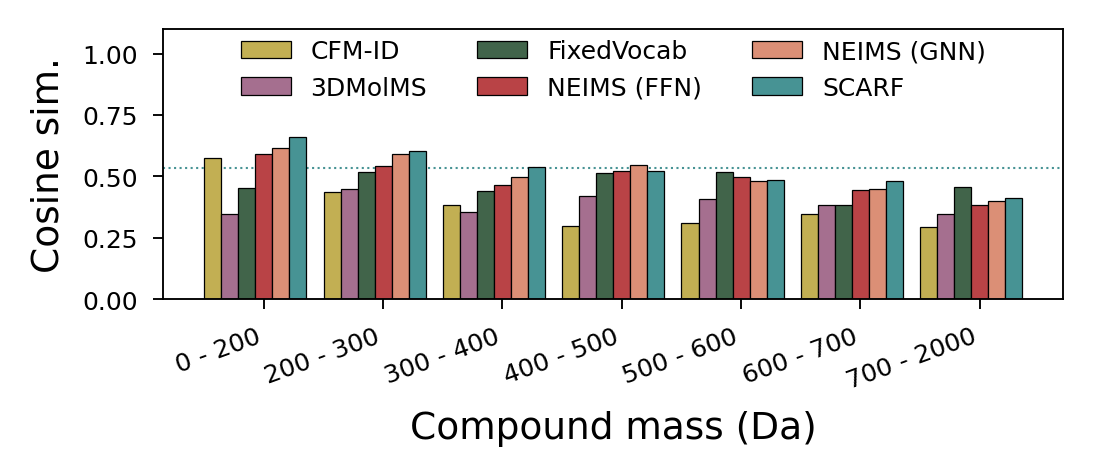

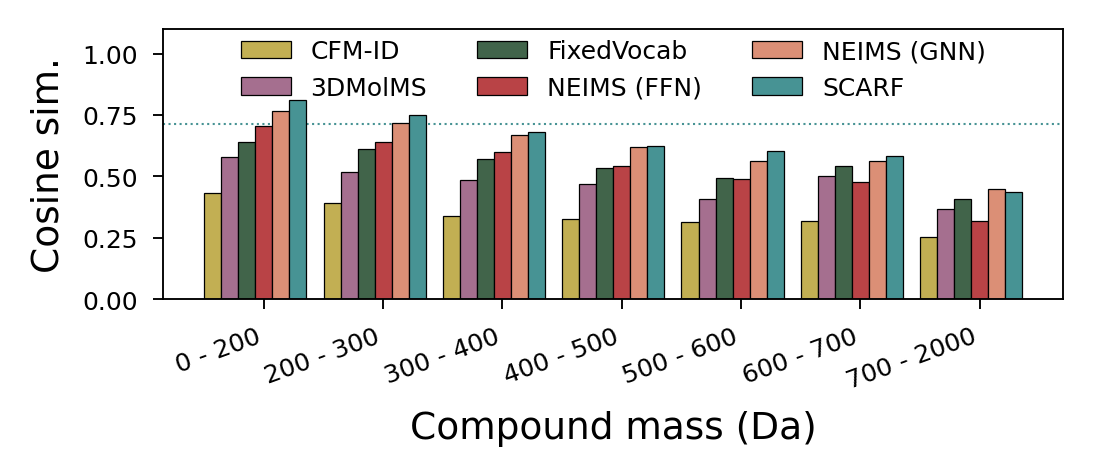

In [23]:
color_dict = method_colors
methods = [*names, "ghost_method"]
bins = np.array(['0 - 200', '200 - 300', '300 - 400', '400 - 500', 
                 '500 - 600', '600 - 700', '700 - 2000',])
for dataset, sub_df in out_df.groupby("dataset"):
    figsize = (3,0.9)
    metric = "cos_sim"
    method_col = "method"
    groupby_col = "mass_bin"
    # Plot a groupbed barplot where each method has a color (color_dict) and x axis is the groupby col
    fig = plt.figure(figsize=figsize, dpi=300)
    ax = fig.add_subplot(111)
    x_values = np.arange(len(pd.unique(sub_df[groupby_col])))
    shift_val = 1 / (len(methods))
    shift_bw = np.arange(len(bins)).repeat(len(methods))
    # Plot scarf mean accuracy in dotted horizontal line
    scarf_mean_acc = sub_df[sub_df[method_col] == "SCARF"][metric].mean()
    ax.axhline(y=scarf_mean_acc, color=color_dict['SCARF'], linestyle="dotted", linewidth=0.5, zorder=0)
    
    # Loop through each method and plot a grouped bar
    for idx, method in enumerate(methods):
        if method == "ghost_method": continue
        y_values = sub_df[sub_df[method_col] == method].groupby(groupby_col)[metric].mean()
        std_values = sub_df[sub_df[method_col] == method].groupby(groupby_col)[metric].std()
        counts = sub_df[sub_df[method_col] == method].groupby(groupby_col)[metric].count()

        y_values = y_values[bins]
        counts = counts[bins]
        std_values = std_values[bins] * 1.96 / np.sqrt(counts)
        ax.bar(
            x_values + idx * shift_val,  # Adjust the spacing between bars if needed
            y_values,
            #yerr=std_values,  # Add error bars representing the standard deviation
            capsize=0.6,  # Adjust cap size of the error bars
            error_kw={"elinewidth": 0.5, "capthick": 0.5},  # Adjust error bar thickness
            width=shift_val,  # Adjust the bar width if needed
            label=method,
            color=color_dict.get(method, "gray"),  # Use gray if method color is not defined
            edgecolor="black",  # Add a black edge to the bars
            linewidth=0.3,
            # Make err size smaller

        )

    # Set labels and title
    ax.set_xlabel("Compound mass (Da)")
    ax.set_ylabel("Cosine sim.")
    ax.set_xticks(x_values + (len(methods) - 1) * shift_val/2)
    ax.set_xticklabels(bins, rotation=20, ha="right")  # Use index of group_means as x tick labels
    # Use 3 columns/two rows and poostiion in top of chart inset 
    ax.legend(loc="upper center", borderaxespad=0.,  frameon=False, ncol=3, bbox_to_anchor=(0.5, 1.0))
    ax.set_ylim([0, 1.1])
    set_size(*figsize, ax)

    plt.savefig(res_folder / f"cosine_sim_{dataset}_mass.pdf",  bbox_inches="tight", dpi=300,
                transparent=True
    )

    # Plot a barplot of sub_df where 

## Accuracy by chemical class

In [24]:
ikey_to_class_files = [f"../results/dataset_analyses/{i}/ikey_to_classes.p" for i in dataset_names]
ikey_to_class = {k:v for f in ikey_to_class_files for k,v in pickle.load(open(f, "rb")).items()}

In [25]:
new_df = []
for _, row in out_df.iterrows():
    new_dict = row.to_dict()
    ikey = new_dict['inchi']
    classif_out = ikey_to_class[ikey]
    for chem_class in classif_out.get("superclass_results", []):
        temp_dict = dict(**new_dict, chem_class=chem_class)
        new_df.append(temp_dict)
class_df = pd.DataFrame(new_df)


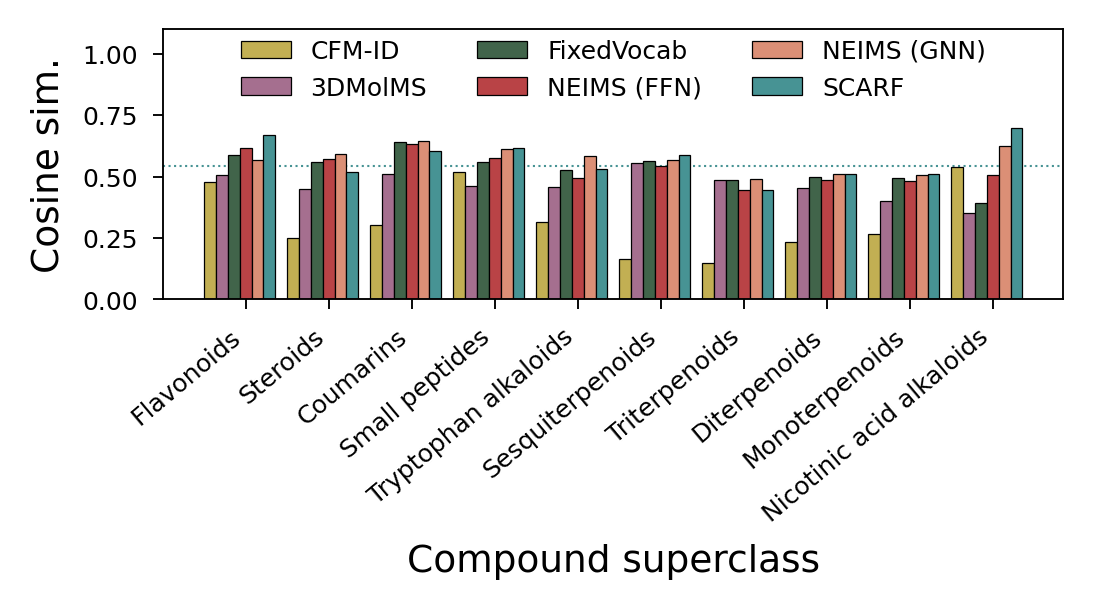

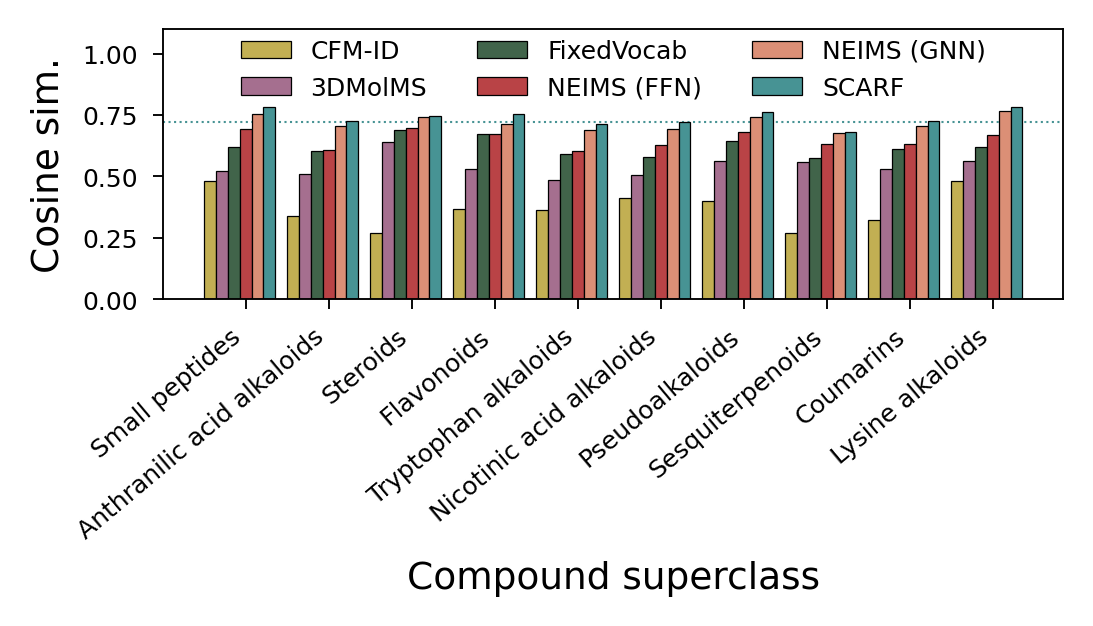

In [26]:
num_classes = 10
color_dict = method_colors
methods = [*names, "ghost_method"]
for dataset, sub_df in class_df.groupby("dataset"):
    figsize = (3,0.9)
    metric = "cos_sim"
    method_col = "method"
    groupby_col = "chem_class"
    # Get 10 most common classes
    classes = sub_df.groupby(groupby_col)[metric].count().sort_values(ascending=False).head(num_classes).index

    # Plot a groupbed barplot where each method has a color (color_dict) and x axis is the groupby col
    fig = plt.figure(figsize=figsize, dpi=300)
    ax = fig.add_subplot(111)
    x_values = np.arange(len(classes))
    shift_val = 1 / (len(methods))
    shift_bw = np.arange(len(classes)).repeat(len(methods))
    
    # Plot scarf mean accuracy in dotted horizontal line
    scarf_mean_acc = sub_df[sub_df[method_col] == "SCARF"][metric].mean()
    ax.axhline(y=scarf_mean_acc, color=color_dict['SCARF'], linestyle="dotted", linewidth=0.5, zorder=0)

    # Loop through each method and plot a grouped bar
    for idx, method in enumerate(methods):
        if method == "ghost_method": continue
        y_values = sub_df[sub_df[method_col] == method].groupby(groupby_col)[metric].mean()
        std_values = sub_df[sub_df[method_col] == method].groupby(groupby_col)[metric].std()
        counts = sub_df[sub_df[method_col] == method].groupby(groupby_col)[metric].count()

        y_values = y_values[classes]
        counts = counts[classes]
        std_values = std_values[classes] * 1.96 / np.sqrt(counts)
        ax.bar(
            x_values + idx * shift_val,  # Adjust the spacing between bars if needed
            y_values,
            #yerr=std_values,  # Add error bars representing the standard deviation
            capsize=0.6,  # Adjust cap size of the error bars
            error_kw={"elinewidth": 0.5, "capthick": 0.5},  # Adjust error bar thickness
            width=shift_val,  # Adjust the bar width if needed
            label=method,
            color=color_dict.get(method, "gray"),  # Use gray if method color is not defined
            edgecolor="black",  # Add a black edge to the bars
            linewidth=0.3,
            # Make err size smaller
        )
    

    # Set labels and title
    ax.set_xlabel("Compound superclass")
    ax.set_ylabel("Cosine sim.")
    ax.set_xticks(x_values + (len(methods) - 1) * shift_val/2)
    ax.set_xticklabels(classes, rotation=40, ha="right")  # Use index of group_means as x tick labels
    # Use 3 columns/two rows and poostiion in top of chart inset 
    ax.legend(loc="upper center", borderaxespad=0.,  frameon=False, ncol=3, bbox_to_anchor=(0.5, 1.0))
    ax.set_ylim([0, 1.1])
    set_size(*figsize, ax)

    plt.savefig(res_folder / f"cosine_sim_{dataset}_chem_class.pdf",  bbox_inches="tight", dpi=300,
                transparent=True)

    # Plot a barplot of sub_df where 